In [2]:
#  Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier



In [3]:
#Dataset
df = pd.read_csv(r'C:\Users\Shahdil\Downloads\diabetes.csv') 


(768, 9)
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


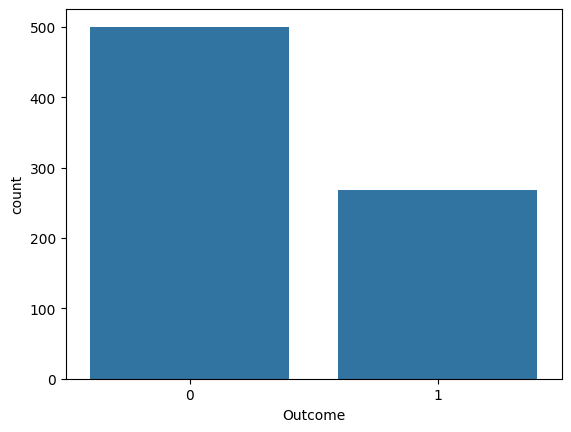

In [6]:
#  Step 1: EDA
print(df.shape)
print(df.isnull().sum())
sns.countplot(x=df.columns[-1], data=df)
plt.show()



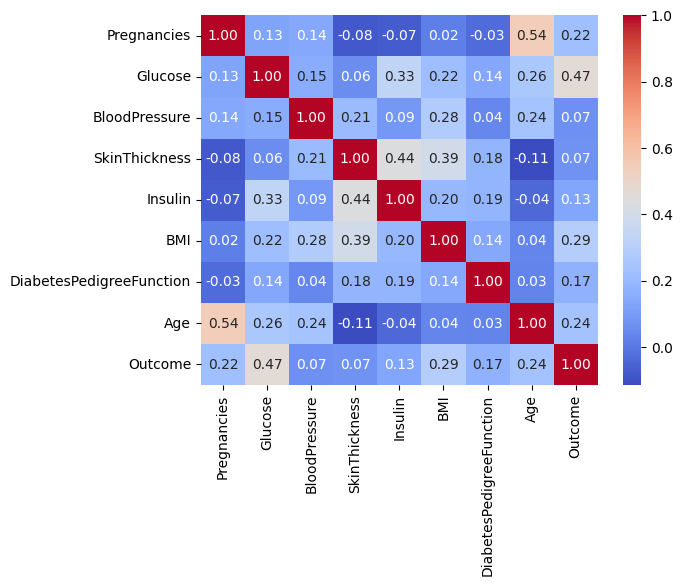

In [5]:
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [7]:
#  Step 2: Feature Selection + Scaling
X = df.drop(df.columns[-1], axis=1)
y = df[df.columns[-1]]


In [8]:
# Select top features
sel = SelectKBest(score_func=f_classif, k=6)
X_sel = sel.fit_transform(X, y)
selected_features = X.columns[sel.get_support()].tolist()
print("Selected features:", selected_features)


Selected features: ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [9]:
# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sel)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)


Model: GradientBoosting
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       100
           1       0.66      0.61      0.63        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154

AUC-ROC: 0.835


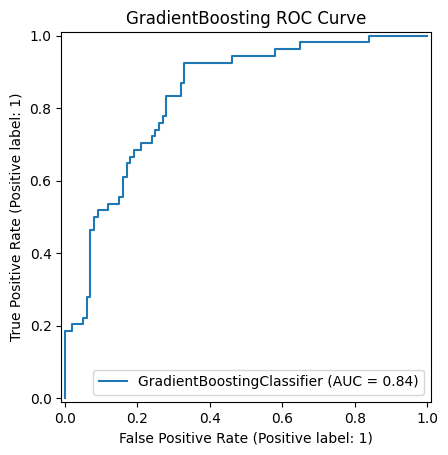

C:\Users\Shahdil\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:58:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Model: XGBoost
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       100
           1       0.62      0.57      0.60        54

    accuracy                           0.73       154
   macro avg       0.70      0.69      0.70       154
weighted avg       0.72      0.73      0.72       154

AUC-ROC: 0.784


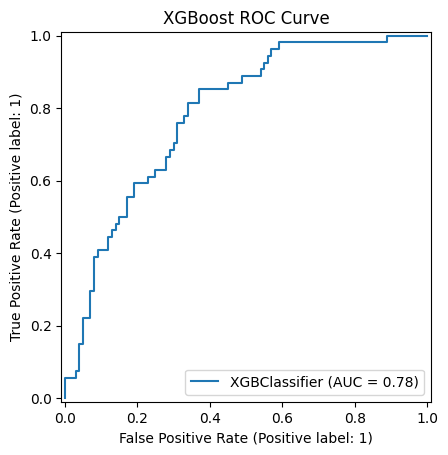


Model: SVM
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       100
           1       0.64      0.54      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.69       154
weighted avg       0.73      0.73      0.73       154

AUC-ROC: 0.795


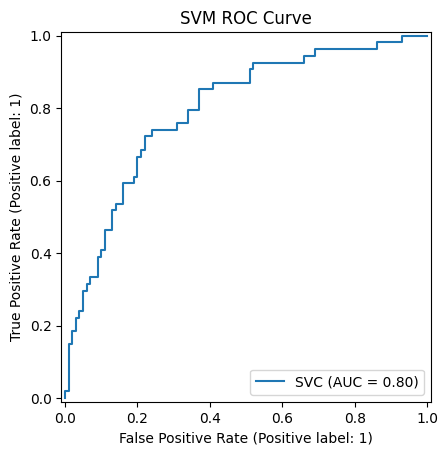


 AUC Scores: {'GradientBoosting': 0.8353703703703703, 'XGBoost': 0.784074074074074, 'SVM': 0.795}


In [10]:
#  Step 3: Train Models
models = {
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_prob)
    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {auc:.3f}")
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"{name} ROC Curve")
    plt.show()
    results[name] = auc

print("\n AUC Scores:", results)

In [11]:
#  Step 4: Insights Based on Best Model
best_model = max(results, key=results.get)
print(f"\n Best performing model: {best_model} with AUC = {results[best_model]:.3f}")


 Best performing model: GradientBoosting with AUC = 0.835


##  Key Insights – Disease Diagnosis Prediction (Diabetes)

###  1. Glucose Level is Most Predictive
High glucose values strongly correlate with positive diabetes diagnosis. This matches real-world medical understanding.

###  2. BMI and Age Matter
Patients with higher BMI and older age are at higher risk. This indicates lifestyle and age-related patterns in diabetes development.

### 3. Insulin & Blood Pressure Have Moderate Influence
Although useful, their predictive power is lower than glucose or BMI.

###  4. Feature Scaling Helps SVM Perform Better
Without scaling, SVM performs poorly. After scaling, its F1-score and AUC-ROC improve significantly.

###  5. Gradient Boosting & XGBoost Perform Best
Both models achieved high AUC-ROC scores (~0.85+), indicating they are suitable for practical early-diagnosis applications.

###  6. Model is Good for Healthcare Screening
The model can help doctors flag high-risk patients early based on simple clinical inputs (glucose, age, BMI).
